In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

from datetime import datetime
import functools
import matplotlib.pyplot as plt
import numpy as np

from datasets.shapenet_data_pc import ShapeNet15kPointClouds
from models_adl4cv.pvcnn import PVCNNUp, PVCNN, PVCNNPartSeg
from models_adl4cv.loss import get_repulsion_loss4

from metrics.ChamferDistancePytorch.chamfer_python import distChamfer
from metrics.PyTorchEMD.emd import earth_mover_distance as EMD

from visuals.visuals_util import rotate_point_cloud_x, rotate_point_cloud_z, rotate_point_cloud_y, visualize_pointcloud_eval, save_fig, visualize_pointcloud_eval_three, visualize_pointcloud

# Prepare Datasets and DataLoaders

In [3]:
NPOINTS = 2048 * 2
CATEGORY = "chair"

In [4]:
tr_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=[CATEGORY], split='train',
    tr_sample_size=NPOINTS,
    te_sample_size=NPOINTS,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

val_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=[CATEGORY], split='val',
    tr_sample_size=NPOINTS,
    te_sample_size=NPOINTS,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

test_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=[CATEGORY], split='test',
    tr_sample_size=NPOINTS,
    te_sample_size=NPOINTS,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

Total number of data:4612
Min number of points: (train)4096 (test)4096
Total number of data:662
Min number of points: (train)4096 (test)4096
Total number of data:1317
Min number of points: (train)4096 (test)4096


In [16]:
sample_1 = tr_dataset[0]["train_points"]
sample_2 = tr_dataset[0]["train_points"]

torch.all(sample_1 == sample_2)

tensor(72)

In [5]:
(64 * 32 * 32 * 32) / 10**9

0.002097152

In [7]:
train_dataloader = torch.utils.data.DataLoader(tr_dataset, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

In [8]:
len(tr_dataset), len(val_dataset), len(test_dataset)

(4612, 662, 1317)

In [9]:
def add_random_noise(point_cloud, mean=0, std=0.05):
    noise = torch.normal(mean, std, size=point_cloud.size()).to("cuda")
    point_cloud_noise = point_cloud + noise
    return point_cloud_noise

In [10]:
def chamfer_distance(a, b):
    min_dist_a_to_b, min_dist_b_to_a, _, _ = distChamfer(a, b)
    return (min_dist_a_to_b.mean() + min_dist_b_to_a.mean()) / 2

In [11]:
def EMD_loss(a,b):
    return EMD(a,b, transpose=False).mean()

In [12]:
def combined_loss(input, output):
    # Expects output of shape: [B, N, C]
    emd_loss = EMD_loss(input, output)
    repulsion_loss = get_repulsion_loss4(output)

    # Same as in https://github.com/yulequan/PU-Net/blob/master/code/model_utils.py
    return 100 * emd_loss + repulsion_loss

In [13]:
def subsample(pc, npoints=2048):
    # pc: [B, N, C] N <= npoints
    _, N, _ = pc.shape
    assert npoints <= N

    idx = np.random.choice(N, npoints)
    return pc[:,idx,:]

In [14]:
model = PVCNNUp(num_classes=3, num_shapes=3, extra_feature_channels=0).to("cuda")

In [15]:
part_model = PVCNNPartSeg(num_classes=4, num_shapes=3, extra_feature_channels=0).to("cuda")
part_model.load_state_dict(torch.load("output-models/pvcnn-part-segmentation-noise-chair/PVCNN-Part-Segmentation-Noise-Chair-e48.pth"))

<All keys matched successfully>

In [16]:
model_residuals = PVCNN(num_classes=3, num_shapes=3, extra_feature_channels=4).to("cuda")
model_residuals.load_state_dict(torch.load("output-models/pvcnn-refinement-part-class-chair/PVCNN-Baseline-Refinement-Part-Class-Chair-Residuals-0.05-Noise-e8.pth"))

<All keys matched successfully>

In [17]:
# TensorBoard Logging with model's name and current date
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
model_name = 'PVCNN-Residuals-Class-Conditions-And-Upsample-Global-Chair-One-Hot'
log_dir = f"runs/{model_name}_{current_time}"
writer = SummaryWriter(log_dir=log_dir)

# Optimization
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.998)

# Losses
training_losses = []
val_losses = []

# Early Stopping (patience)
best_val_loss = np.inf
patience = 10
patience_counter = 0

In [22]:
for epoch in range(100):
    total_train_loss = 0
    total_val_loss = 0

    # Train
    model.train()
    for batch in train_dataloader:
        input = batch["train_points"].to("cuda")

        input_downsampled = subsample(input)
        # Add noise to the input
        noised_downsampled_input = add_random_noise(input_downsampled)
        
        # Let's segment the input into parts and extract the part assignment.
        input_seg = part_model(noised_downsampled_input.transpose(1,2)).transpose(1,2).data.max(2)[1]

        # One hot encoded
        class_labels_one_hot = F.one_hot(input_seg, num_classes=4)
        combined_tensor = torch.cat((noised_downsampled_input, class_labels_one_hot), dim=-1)
        output_residuals = model_residuals(combined_tensor.transpose(1,2)).transpose(1,2)

        # Learning to upsample
        denoised_downsampled_input = noised_downsampled_input - output_residuals
        
        optimizer.zero_grad()

        output = model(denoised_downsampled_input.transpose(1,2)).to("cuda").transpose(1,2)
        
        loss = combined_loss(input, output)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    epoch_train_loss = total_train_loss / len(train_dataloader)
    training_losses.append(epoch_train_loss)


    # Validate
    model.eval()
    with torch.no_grad():
        for batch in val_dataloader:
            input = batch["train_points"].to("cuda")

            input_downsampled = subsample(input)
            # Add noise to the input
            noised_downsampled_input = add_random_noise(input_downsampled)
            
            # Let's segment the input into parts and extract the part assignment.
            input_seg = part_model(noised_downsampled_input.transpose(1,2)).transpose(1,2).data.max(2)[1]

            # One hot encoded
            class_labels_one_hot = F.one_hot(input_seg, num_classes=4)
            combined_tensor = torch.cat((noised_downsampled_input, class_labels_one_hot), dim=-1)
            output_residuals = model_residuals(combined_tensor.transpose(1,2)).transpose(1,2)

            # Upsample time
            denoised_downsampled_input = noised_downsampled_input - output_residuals
            output = model(denoised_downsampled_input.transpose(1,2)).to("cuda").transpose(1,2)
            
            val_loss = combined_loss(input, output)

            total_val_loss += val_loss.item()

    epoch_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(epoch_val_loss)

    writer.add_scalar('Loss/train', epoch_train_loss, epoch)
    writer.add_scalar('Loss/val', epoch_val_loss, epoch)

    print(f"Epoch {epoch+1},  Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

    # Check for improvement
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0  # reset the patience counter
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epochs.")

    # Break the loop if patience exceeded
    if patience_counter >= patience:
        print("Stopping early due to no improvement in validation loss.")
        break

    # Save the model
    model_save_path = f"output-models/pvcnn-upsample-global-chair/PVCNN-Residuals-Class-Conditions-And-Upsample-Global-Chair-e{epoch+1}.pth"
    torch.save(model.state_dict(), model_save_path)


writer.close()

KeyboardInterrupt: 

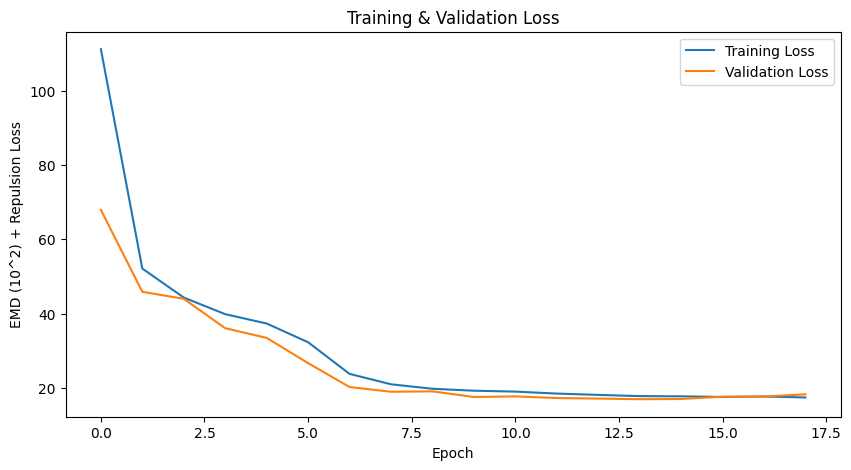

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('EMD (10^2) + Repulsion Loss')
plt.legend()
plt.show()

torch.Size([4096, 3]) torch.Size([2048, 3]) torch.Size([4096, 3])


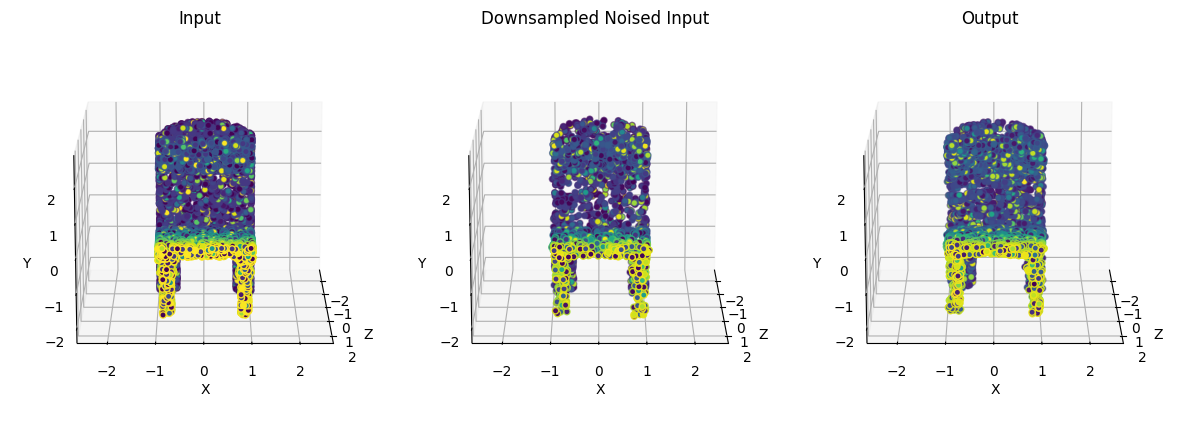

In [27]:
INDEX = 1
input_pc = input[INDEX, ...].detach()
noised_input_pc = denoised_downsampled_input[INDEX, ...].detach()
output_pc = output[INDEX, ...].detach()
print(input_pc.shape, noised_input_pc.shape, output_pc.shape)

fig = visualize_pointcloud_eval_three(input_pc, noised_input_pc, output_pc, 
                                "Input", "Downsampled Noised Input", "Output")

# Let's visualize some examples

In [14]:
# Run this if you need to load the model.

model = PVCNNUp(num_classes=3, num_shapes=3, extra_feature_channels=0).to("cuda")
model.load_state_dict(torch.load("output-models/pvcnn-upsample-global-chair/PVCNN-Residuals-Class-Conditions-And-Upsample-Global-Chair-e33.pth"))

<All keys matched successfully>

# Evaluate the trained PVCNN

In [24]:
model.eval()

total_test_loss = 0

input_arr = []
output_arr = []

for i, batch in enumerate(test_dataloader):
    with torch.no_grad():
        input = batch["train_points"].to("cuda")

        input_downsampled = subsample(input)
        # Add noise to the input
        noised_downsampled_input = add_random_noise(input_downsampled)
        
        # Let's segment the input into parts and extract the part assignment.
        input_seg = part_model(noised_downsampled_input.transpose(1,2)).transpose(1,2).data.max(2)[1]

        # One hot encoded
        class_labels_one_hot = F.one_hot(input_seg, num_classes=4)
        combined_tensor = torch.cat((noised_downsampled_input, class_labels_one_hot), dim=-1)
        output_residuals = model_residuals(combined_tensor.transpose(1,2)).transpose(1,2)

        # Upsample time
        denoised_downsampled_input = noised_downsampled_input - output_residuals
        output = model(denoised_downsampled_input.transpose(1,2)).to("cuda").transpose(1,2)
            
        input_arr.append(input)
        output_arr.append(output)

        loss = combined_loss(input, output)
        total_test_loss += loss.item()
        print(f"Batch {i}, EMD + Repulsion Loss: {loss.item():.4f}")

average_loss = total_test_loss / len(test_dataloader)
print(f"TOTAL CD Loss: {average_loss:.4f}")

Batch 0, EMD + Repulsion Loss: 19.2581
Batch 1, EMD + Repulsion Loss: 18.3816
Batch 2, EMD + Repulsion Loss: 17.9379
Batch 3, EMD + Repulsion Loss: 19.7854
Batch 4, EMD + Repulsion Loss: 17.7369
Batch 5, EMD + Repulsion Loss: 15.5655
Batch 6, EMD + Repulsion Loss: 17.8317
Batch 7, EMD + Repulsion Loss: 16.5626
Batch 8, EMD + Repulsion Loss: 17.2173
Batch 9, EMD + Repulsion Loss: 18.3281
Batch 10, EMD + Repulsion Loss: 17.1350
Batch 11, EMD + Repulsion Loss: 14.2314
Batch 12, EMD + Repulsion Loss: 17.0730
Batch 13, EMD + Repulsion Loss: 20.0538
Batch 14, EMD + Repulsion Loss: 17.0433
Batch 15, EMD + Repulsion Loss: 16.4953
Batch 16, EMD + Repulsion Loss: 18.8754
Batch 17, EMD + Repulsion Loss: 17.3925
Batch 18, EMD + Repulsion Loss: 16.9653
Batch 19, EMD + Repulsion Loss: 16.9682
Batch 20, EMD + Repulsion Loss: 18.3262
Batch 21, EMD + Repulsion Loss: 15.1500
Batch 22, EMD + Repulsion Loss: 16.6710
Batch 23, EMD + Repulsion Loss: 16.1611
Batch 24, EMD + Repulsion Loss: 18.2444
Batch 25, 

# Let's now try to imrpove the dataset of PVD

In [35]:
from datasets.pvd_data_pc import ShapeNet15kPointCloudsPVD

dataset_pvd = ShapeNet15kPointCloudsPVD(root_dir="./custom-dataset",
    categories=[CATEGORY], split='train',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

dataloader_pvd = torch.utils.data.DataLoader(dataset_pvd, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

Total number of data:400
Min number of points: (train)2048 (test)2048


In [33]:
input_array = []

for batch in val_dataloader:
    input = batch["test_points"].to("cuda")
    input_array.append(input)

In [36]:
model.eval()

output_array = []
for batch in dataloader_pvd:
    with torch.no_grad():
        input = batch["train_points"].to("cuda")
        
        # Let's segment the input into parts and extract the part assignment.
        input_seg = part_model(input.transpose(1,2)).transpose(1,2).data.max(2)[1]

        # One hot encoded
        class_labels_one_hot = F.one_hot(input_seg, num_classes=4)
        combined_tensor = torch.cat((input, class_labels_one_hot), dim=-1)
        output_residuals = model_residuals(combined_tensor.transpose(1,2)).transpose(1,2)

        # Upsample time
        denoised_downsampled_input = input - output_residuals
        output = model(denoised_downsampled_input.transpose(1,2)).to("cuda").transpose(1,2)
        
        output_array.append(output)

In [37]:
len(input_array), len(output_array)

(33, 20)

In [38]:
input_pcs = torch.stack(input_array[:20]).view(400, NPOINTS, 3)
output_pcs = torch.stack(output_array).view(400, NPOINTS, 3)
input_pcs.shape, output_pcs.shape

(torch.Size([400, 4096, 3]), torch.Size([400, 4096, 3]))

In [70]:
from metrics.evaluation_metrics import compute_all_metrics

results = compute_all_metrics(input_pcs, output_pcs, 100)
results = {k: (v.cpu().detach().item()
                if not isinstance(v, float) else v) for k, v in results.items()}

print(results)

  0%|          | 0/400 [00:00<?, ?it/s]

Jitting Chamfer 3D
Loaded JIT 3D CUDA chamfer distance


100%|██████████| 400/400 [14:59<00:00,  2.25s/it]

{'lgan_mmd-CD': 0.08332142233848572, 'lgan_cov-CD': 0.5274999737739563, 'lgan_mmd_smp-CD': 0.09798721224069595, 'lgan_mmd-EMD': 0.5351982712745667, 'lgan_cov-EMD': 0.5224999785423279, 'lgan_mmd_smp-EMD': 0.5896612405776978, '1-NN-CD-acc_t': 0.6825000047683716, '1-NN-CD-acc_f': 0.5475000143051147, '1-NN-CD-acc': 0.6150000095367432, '1-NN-EMD-acc_t': 0.6299999952316284, '1-NN-EMD-acc_f': 0.5425000190734863, '1-NN-EMD-acc': 0.5862500071525574}


In [ ]:
airplane = {
    "lgan_mmd-CD": 0.08332142233848572,
    "lgan_cov-CD": 0.5274999737739563,
    "lgan_mmd_smp-CD": 0.09798721224069595,
    "lgan_mmd-EMD": 0.5351982712745667,
    "lgan_cov-EMD": 0.5224999785423279,
    "lgan_mmd_smp-EMD": 0.5896612405776978,
    "1-NN-CD-acc_t": 0.6825000047683716,
    "1-NN-CD-acc_f": 0.5475000143051147,
    "1-NN-CD-acc": 0.6150000095367432,
    "1-NN-EMD-acc_t": 0.6299999952316284,
    "1-NN-EMD-acc_f": 0.5425000190734863,
    "1-NN-EMD-acc": 0.5862500071525574,
}

# 1-NNA-CD: 61.5%
# 1-NNA-EMD: 58.62%

torch.Size([2048, 3]) torch.Size([4096, 3])


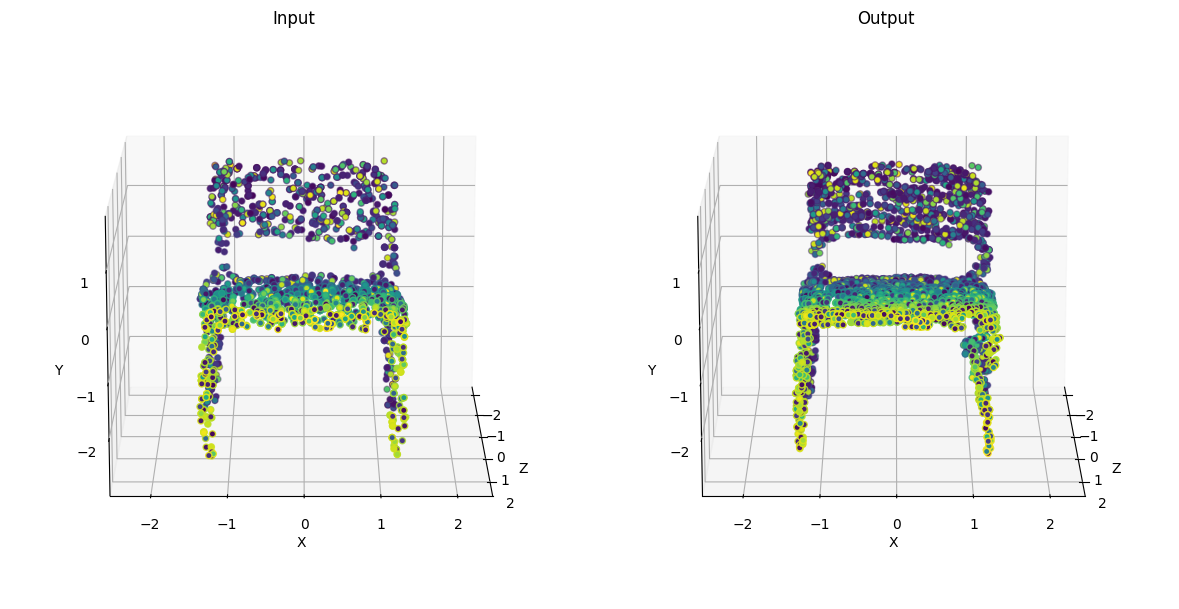

In [65]:
INDEX = 5
input_pc = input[INDEX, ...].detach()
output_pc = output[INDEX, ...].detach()
print(input_pc.shape, output_pc.shape)

fig = visualize_pointcloud_eval(input_pc, output_pc, "Input", "Output")

In [40]:
chamfer_distance(input_pc.unsqueeze(0), output_pc.unsqueeze(0))

tensor(0.0051, device='cuda:0')

In [41]:
EMD_loss(input_pc.unsqueeze(0), output_pc.unsqueeze(0))

tensor(0.1633, device='cuda:0')

In [42]:
get_repulsion_loss4(output_pc.unsqueeze(0))

tensor(0.0700, device='cuda:0')

In [32]:
output_pc[0, ...], output_pc[2048,...]

(tensor([ 0.9828, -0.5207,  0.0653], device='cuda:0'),
 tensor([ 0.9501, -0.5032,  0.0608], device='cuda:0'))

In [66]:
from visuals.mitsuba_vis import render_mitsuba
import matplotlib.pyplot as plt

input_img = render_mitsuba(input_pc.cpu().numpy(), "./input.xml", fov=20, radius=0.015)
output_img = render_mitsuba(output_pc.cpu().numpy(), "./output.xml", fov=20, radius=0.015)

Center: [ 0.03717339 -0.5307273  -0.08223593], Scale: 4.79085636138916
Center: [ 0.0019539  -0.48321545 -0.09063751], Scale: 4.546751976013184


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


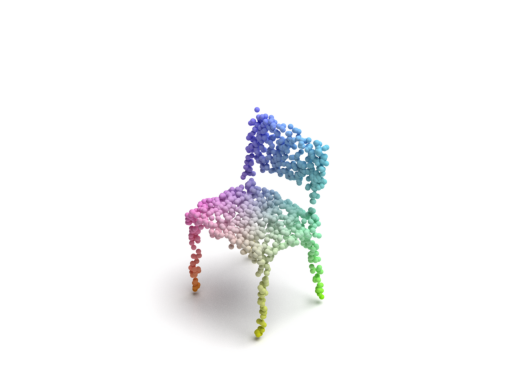

In [67]:
plt.axis("off")
plt.imshow(input_img ** (1.0 / 2.2)) # approximate sRGB tonemapping
plt.savefig("Input-Chair-PVD.png", bbox_inches='tight', pad_inches=0, dpi=400)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


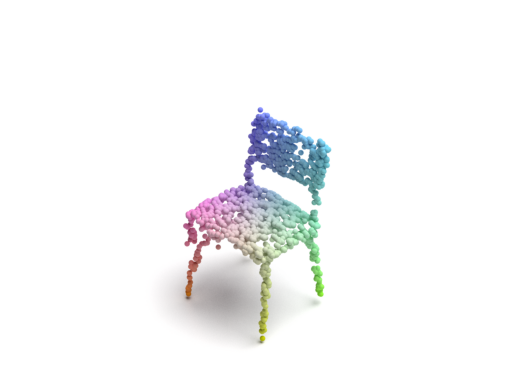

In [68]:
plt.axis("off")
plt.imshow(output_img ** (1.0 / 2.2)) # approximate sRGB tonemapping
plt.savefig("Output-Upsampled-Chair-PVD.png", bbox_inches='tight', pad_inches=0, dpi=400)